<a href="https://colab.research.google.com/github/EstebanHernandezCapel/TFE/blob/main/wind_cond_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import

In [1]:
# -*- coding: utf-8 -*-

import math
import os
import json
import pickle
import random
from math import sqrt
from functools import reduce
# import wandb

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.benchmark import timer
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

!pip install numpyencoder
from numpyencoder import NumpyEncoder

import datetime
from joblib import dump, load
import joblib
import timeit
import imageio



from google.colab import drive
drive.mount('/content/drive')

def time_format(t):
    if t > 60 * 60:
        h = t //(60*60)
        m = t % (60*60)
        s = m % 60
        m = m // 60
        return f"{h} hours {m} minutes {s} seconds"
    elif t > 60:
        s = t % (60)
        m = t // 60
        return f"{m} minutes {s} seconds"
    else:
        return f"{t} seconds"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive


#Loading and data Utility function

In [2]:
def periods_where_pv_is_null(df_inputs:pd.DataFrame):
    """
    Compute the time periods where the PV generation is always 0 for the solar track.
    :param df_inputs: solar track data.
    :return: indices where PV is always 0.
    """
    # Determine time periods where PV generation is 0
    nb_days = int(df_inputs[df_inputs['ZONE_1'] == 1]['POWER'].shape[0] / 24)
    max_zone1 = df_inputs[df_inputs['ZONE_1'] == 1]['POWER'].values.reshape(nb_days, 24).max(axis=0)
    max_zone2 = df_inputs[df_inputs['ZONE_2'] == 1]['POWER'].values.reshape(nb_days, 24).max(axis=0)
    max_zone3 = df_inputs[df_inputs['ZONE_3'] == 1]['POWER'].values.reshape(nb_days, 24).max(axis=0)

    indices1 = np.where(max_zone1 == 0)[0]
    indices2 = np.where(max_zone2 == 0)[0]
    indices3 = np.where(max_zone3 == 0)[0]

    print('zone 1', indices1)
    print('zone 2', indices2)
    print('zone 3', indices3)

    return indices1

def wind_data(path_name: str, random_state: int = 0, test_size:int=2*12*2):
    """
    Build the wind power data for the GEFcom IJF_paper case study.
    """

    df_wind = pd.read_csv(path_name, parse_dates=True, index_col=0)
    ZONES = ['ZONE_' + str(i) for i in range(1, 10 + 1)]

    # INPUTS DESCRIPTION
    # The predictors included wind forecasts at two heights, 10 and 100 m above ground level, obtained from the European Centre for Medium-range Weather Forecasts (ECMWF).
    # These forecasts were for the zonal and meridional wind components (denoted u and v), i.e., projections of the wind vector on the west-east and south-north axes, respectively.

    # U10 zonal wind component at 10 m
    # V10 meridional wind component at 10 m
    # U100 zonal wind component at 100 m
    # V100 meridional wind component at 100 m

    # ------------------------------------------------------------------------------------------------------------------
    # Build derived features
    # cf winner GEFcom2014 wind track “Probabilistic gradient boosting machines for GEFCom2014 wind forecasting”
    # ------------------------------------------------------------------------------------------------------------------

    # the wind speed (ws), wind energy (we), and wind direction (wd) were as follows,
    # where u and v are the wind components provided and d is the density, for which we used a constant 1.0
    # ws = sqrt[u**2  + v**2]
    # we = 0.5 × d × ws**3
    # wd = 180/π × arctan(u, v)

    df_wind['ws10'] = np.sqrt(df_wind['U10'].values ** 2 + df_wind['V10'].values ** 2)
    df_wind['ws100'] = np.sqrt(df_wind['U100'].values ** 2 + df_wind['V100'].values ** 2)
    df_wind['we10'] = 0.5 * 1 * df_wind['ws10'].values ** 3
    df_wind['we100'] = 0.5 * 1 * df_wind['ws100'].values ** 3
    df_wind['wd10'] = np.arctan2(df_wind['U10'].values, df_wind['V10'].values) * 180 / np.pi
    df_wind['wd100'] = np.arctan2(df_wind['U100'].values, df_wind['V100'].values) * 180 / np.pi

    features = ['U10', 'V10', 'U100', 'V100', 'ws10', 'ws100', 'we10', 'we100', 'wd10', 'wd100']

    data_zone = []
    for zone in ZONES:
        df_var = df_wind[df_wind[zone] == 1].copy()
        nb_days = int(len(df_var) / 24)
        zones = [df_var[zone].values.reshape(nb_days, 24)[:, 0].reshape(nb_days, 1) for zone in ZONES]
        x = np.concatenate([df_var[col].values.reshape(nb_days, 24) for col in features] + zones, axis=1)
        y = df_var['TARGETVAR'].values.reshape(nb_days, 24)
        df_y = pd.DataFrame(data=y, index=df_var['TARGETVAR'].asfreq('D').index)
        df_x = pd.DataFrame(data=x, index=df_var['TARGETVAR'].asfreq('D').index)

        # Decomposition between LS, VS & TEST sets (TRAIN = LS + VS)
        df_x_train, df_x_TEST, df_y_train, df_y_TEST = train_test_split(df_x, df_y, test_size=test_size,random_state=random_state, shuffle=True)
        df_x_LS, df_x_VS, df_y_LS, df_y_VS = train_test_split(df_x_train, df_y_train, test_size=test_size,random_state=random_state, shuffle=True)

        data_zone.append([df_x_LS, df_y_LS, df_x_VS, df_y_VS, df_x_TEST, df_y_TEST])

        nb_days_LS = len(df_y_LS)
        nb_days_VS = len(df_y_VS)
        nb_days_TEST = len(df_y_TEST)
        print('#LS %s days #VS %s days # TEST %s days' % (nb_days_LS, nb_days_VS, nb_days_TEST))

    return [pd.concat([data_zone[i][j] for i in range(0, 9 + 1)], axis=0, join='inner') for j in range(0, 5 + 1)]


def load_data(path_name: str, random_state: int = 0, test_size:int=2*12*2):
    """
    Build the load power data for the GEFcom IJF_paper case study.
    """
    df_load = pd.read_csv(path_name, parse_dates=True, index_col=0)
    features = ['w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9', 'w10',
                'w11', 'w12', 'w13', 'w14', 'w15', 'w16', 'w17', 'w18', 'w19', 'w20',
                'w21', 'w22', 'w23', 'w24', 'w25']
    max_load = df_load['LOAD'].max()

    nb_days = int(len(df_load) / 24)
    x = np.concatenate([df_load[col].values.reshape(nb_days, 24) for col in features], axis=1)
    y = df_load['LOAD'].values.reshape(nb_days, 24) / max_load
    df_y = pd.DataFrame(data=y, index=df_load['LOAD'].asfreq('D').index)
    df_x = pd.DataFrame(data=x, index=df_load['LOAD'].asfreq('D').index)

    # Decomposition between LS, VS & TEST sets (TRAIN = LS + VS)
    df_x_train, df_x_TEST, df_y_train, df_y_TEST = train_test_split(df_x, df_y, test_size=test_size,
                                                                    random_state=random_state, shuffle=True)
    df_x_LS, df_x_VS, df_y_LS, df_y_VS = train_test_split(df_x_train, df_y_train, test_size=test_size,
                                                          random_state=random_state, shuffle=True)

    nb_days_LS = len(df_y_LS)
    nb_days_VS = len(df_y_VS)
    nb_days_TEST = len(df_y_TEST)
    print('#LS %s days #VS %s days # TEST %s days' % (nb_days_LS, nb_days_VS, nb_days_TEST))

    return df_x_LS, df_y_LS, df_x_VS, df_y_VS, df_x_TEST, df_y_TEST


def build_pv_features(df_var:pd.DataFrame, indices:np.array):
    """
    Build features for NFs multi-output.
    :param df_var: (n_periods, n_features)
    :param indices: index where PV generation is always 0.
    # INPUTS DESCRIPTION
    # Variable id. Variable name
    # 078.128 Total column liquid water (tclw)
    # 079.128 Total column ice water (tciw)
    # 134.128 Surface pressure (SP)
    # 157.128 Relative humidity at 1000 mbar (r)
    # 164.128 Total cloud cover (TCC)
    # 165.128 10-metre U wind component (10u)
    # 166.128 10-metre V wind component (10v)
    # 167.128 2-metre temperature (2T)
    # 169.128 Surface solar rad down (SSRD)
    # 175.128 Surface thermal rad down (STRD)
    # 178.128 Top net solar rad (TSR)
    # 228.128 Total precipitation (TP)
    """
    n_days = int(len(df_var) / 24)  # n days

    # Reshaping features from (24 * n_days,) to (n_days, 24) then drop time periods where PV is always 0
    y = df_var['POWER'].values.reshape(n_days, 24)
    y = np.delete(y, indices, axis=1)

    tclw = df_var['VAR78'].values.reshape(n_days, 24)
    tclw = np.delete(tclw, indices, axis=1)
    tciw = df_var['VAR79'].values.reshape(n_days, 24)
    tciw = np.delete(tciw, indices, axis=1)
    sp = df_var['VAR134'].values.reshape(n_days, 24)
    sp = np.delete(sp, indices, axis=1)
    rh = df_var['VAR157'].values.reshape(n_days, 24)
    rh = np.delete(rh, indices, axis=1)
    TCC = df_var['VAR164'].values.reshape(n_days, 24)
    TCC = np.delete(TCC, indices, axis=1)
    windU = df_var['VAR165'].values.reshape(n_days, 24)
    windU = np.delete(windU, indices, axis=1)
    windV = df_var['VAR166'].values.reshape(n_days, 24)
    windV = np.delete(windV, indices, axis=1)
    TT = df_var['VAR167'].values.reshape(n_days, 24)
    TT = np.delete(TT, indices, axis=1)
    SSRD = df_var['VAR169'].values.reshape(n_days, 24)
    SSRD = np.delete(SSRD, indices, axis=1)
    STRD = df_var['VAR175'].values.reshape(n_days, 24)
    STRD = np.delete(STRD, indices, axis=1)
    TSR = df_var['VAR178'].values.reshape(n_days, 24)
    TSR = np.delete(TSR, indices, axis=1)
    TP = df_var['VAR228'].values.reshape(n_days, 24)
    TP = np.delete(TP, indices, axis=1)
    zone1 = df_var['ZONE_1'].values.reshape(n_days, 24)[:, 0].reshape(n_days, 1)
    zone2 = df_var['ZONE_2'].values.reshape(n_days, 24)[:, 0].reshape(n_days, 1)
    zone3 = df_var['ZONE_3'].values.reshape(n_days, 24)[:, 0].reshape(n_days, 1)

    x = np.concatenate([TT, SSRD, np.multiply(SSRD, SSRD), np.multiply(SSRD, TT), rh, zone1, zone2, zone3], axis=1)

    return x,y

def pv_data(path_name: str, test_size:int, random_state:int=0):
    """
    Build the PV data for the GEFcom IJF_paper case study.
    """

    df_pv = pd.read_csv(path_name, parse_dates=True, index_col=0)

    ZONES = ['ZONE_1', 'ZONE_2', 'ZONE_3']
    indices = periods_where_pv_is_null(df_inputs=df_pv)

    data_zone = []
    for zone in ZONES:
        df_var = df_pv[df_pv[zone] == 1].copy()
        d_index = df_var['POWER'].asfreq('D').index
        x, y = build_pv_features(df_var=df_var, indices=indices)

        df_y = pd.DataFrame(data=y, index=d_index)
        df_x = pd.DataFrame(data=x, index=d_index)

        # Decomposition between LS, VS & TEST sets (TRAIN = LS + VS)
        df_x_train, df_x_TEST, df_y_train, df_y_TEST = train_test_split(df_x, df_y, test_size=test_size, random_state=random_state, shuffle=True)
        df_x_LS, df_x_VS, df_y_LS, df_y_VS = train_test_split(df_x_train, df_y_train, test_size=test_size, random_state=random_state, shuffle=True)

        data_zone.append([df_x_LS, df_y_LS, df_x_VS, df_y_VS, df_x_TEST, df_y_TEST])

        nb_days_LS = len(df_y_LS)
        nb_days_VS = len(df_y_VS)
        nb_days_TEST = len(df_y_TEST)
        print('%s #LS %s days #VS %s days # TEST %s days' % (zone, nb_days_LS, nb_days_VS, nb_days_TEST))

    return [pd.concat([data_zone[i][j] for i in [0, 1, 2]], axis=0, join='inner') for j in range(0, 5 + 1)], indices


def scale_data_multi(x_LS: np.array, y_LS: np.array, x_VS: np.array, y_VS: np.array, x_TEST: np.array, y_TEST: np.array):
    """
    Scale data for NFs multi-output.
    """
    y_LS_scaler = StandardScaler()
    y_LS_scaler.fit(y_LS)
    y_LS_scaled = y_LS_scaler.transform(y_LS)
    y_VS_scaled = y_LS_scaler.transform(y_VS)
    y_TEST_scaled = y_LS_scaler.transform(y_TEST)

    x_LS_scaler = StandardScaler()
    x_LS_scaler.fit(x_LS)
    x_LS_scaled = x_LS_scaler.transform(x_LS)
    x_VS_scaled = x_LS_scaler.transform(x_VS)
    x_TEST_scaled = x_LS_scaler.transform(x_TEST)

    return x_LS_scaled, y_LS_scaled,  x_VS_scaled, y_VS_scaled, x_TEST_scaled, y_TEST_scaled, y_LS_scaler

# Setup the data

In [3]:
# Set the working directory to the root of the project
print(os.getcwd())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

# ------------------------------------------------------------------------------------------------------------------
# GEFcom IJF_paper case study
# Solar track: 3 zones
# Wind track: 10 zones
# Load track: 1 zones
# 50 days picked randomly per zone for the VS and TEST sets

# Decribe the model here
# ------------------------------------------------------------------------------------------------------------------

tag = 'wind'  # pv, wind, load

gpu = True  # put False to use CPU
print('Using gpu: %s ' % torch.cuda.is_available())
if gpu:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dir_path = 'export/diff_' + tag + '/'
if not os.path.isdir(dir_path):  # test if directory exist
    os.makedirs(dir_path)

# ------------------------------------------------------------------------------------------------------------------
# Built the LS, VS, and TEST sets
# ------------------------------------------------------------------------------------------------------------------

if tag == 'pv':
    # WARNING: the time periods where PV is always 0 (night hours) are removed -> there are 8 periods removed
    # The index of the time periods removed are provided into indices
    data, indices = pv_data(path_name='/content/drive/MyDrive/TFE/data/solar_new.csv', test_size=50, random_state=0)
    ylim_loss = [0, 15]
    ymax_plf = 2.5
    ylim_crps = [0, 12]
    nb_zones = 3

elif tag == 'wind':
    data = wind_data(path_name='/content/drive/MyDrive/TFE/data/wind_data_all_zone.csv', test_size=50, random_state=0)
    ylim_loss = [0, 30]
    ymax_plf = 8
    ylim_crps = [6, 12]
    nb_zones = 10
    indices = []

elif tag == 'load':
    data = load_data(path_name= '/content/drive/MyDrive/TFE/data/load_data_track1.csv', test_size=50, random_state=0)
    ylim_loss = [-5, 10]
    ymax_plf = 2
    ylim_crps = [0, 5]
    nb_zones = 1
    indices = []

# reduce the LS size from 634 days to D days
df_x_LS = data[0].copy()
df_y_LS = data[1].copy()
df_x_VS = data[2].copy()
df_y_VS = data[3].copy()
df_x_TEST = data[4].copy()
df_y_TEST = data[5].copy()

nb_days_LS = len(df_y_LS)
nb_days_VS = len(df_y_VS)
nb_days_TEST = len(df_y_TEST)
print('#LS %s days #VS %s days # TEST %s days' % (nb_days_LS / nb_zones, nb_days_VS / nb_zones, nb_days_TEST / nb_zones))

# ------------------------------------------------------------------------------------------------------------------
# Scale the LS, VS, and TEST sets
# ------------------------------------------------------------------------------------------------------------------

# WARNING: use the scaler fitted on the TRAIN LS SET !!!!
x_LS_scaled, y_LS_scaled, x_VS_scaled, y_VS_scaled, x_TEST_scaled, y_TEST_scaled, y_LS_scaler = scale_data_multi(x_LS=df_x_LS.values, y_LS=df_y_LS.values, x_VS=df_x_VS.values, y_VS=df_y_VS.values, x_TEST=df_x_TEST.values, y_TEST=df_y_TEST.values)

non_null_indexes = list(np.delete(np.asarray([i for i in range(24)]), indices))
 # Rebuilt the PV observations with the removed time periods
if tag == 'pv':
    df_y_TEST.columns = non_null_indexes
    for i in indices:
        df_y_TEST[i] = 0
    df_y_TEST = df_y_TEST.sort_index(axis=1)

    df_y_VS.columns = non_null_indexes
    for i in indices:
        df_y_VS[i] = 0
    df_y_VS = df_y_VS.sort_index(axis=1)

print(tag)

/content
Using gpu: True 
Using gpu: True 
#LS 631 days #VS 50 days # TEST 50 days
#LS 631 days #VS 50 days # TEST 50 days
#LS 631 days #VS 50 days # TEST 50 days
#LS 631 days #VS 50 days # TEST 50 days
#LS 631 days #VS 50 days # TEST 50 days
#LS 631 days #VS 50 days # TEST 50 days
#LS 631 days #VS 50 days # TEST 50 days
#LS 631 days #VS 50 days # TEST 50 days
#LS 631 days #VS 50 days # TEST 50 days
#LS 631 days #VS 50 days # TEST 50 days
#LS 631.0 days #VS 50.0 days # TEST 50.0 days
wind


# Create the LS, VS and TS

(6310, 24)
(6310, 250)
4579


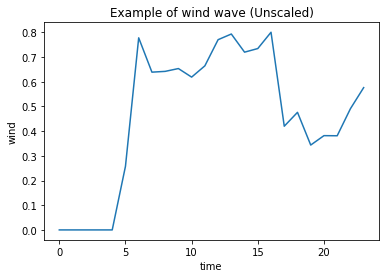

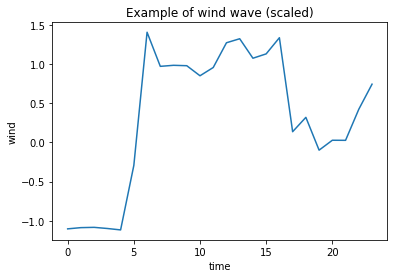

In [4]:
class LoadDataset(Dataset):
  def __init__(self, x, loads, scaler):
    self.x = x
    self.loads = loads
    self.y_scaler = scaler

  def __len__(self):
      return self.loads.shape[0]
  def __getitem__(self, idx):
    return self.loads[idx], self.x[idx]


class WindDataset(Dataset):
  def __init__(self, x, wind, scaler):
    self.x = x
    self.wind = wind
    self.y_scaler = scaler

  def __len__(self):
      return self.wind.shape[0]
  def __getitem__(self, idx):
    return self.wind[idx], self.x[idx]


class SolarDataset(Dataset):
  def __init__(self, x, solar, scaler):
    self.x = x
    self.solar = solar
    self.y_scaler = scaler

  def __len__(self):
      return self.solar.shape[0]
  def __getitem__(self, idx):
    return self.solar[idx], self.x[idx]

if tag == "load":
  train_dataset = LoadDataset(x_LS_scaled, y_LS_scaled, y_LS_scaler)
  val_dataset = LoadDataset(x_VS_scaled, y_VS_scaled, y_LS_scaler)
  test_dataset = LoadDataset(x_TEST_scaled, y_TEST_scaled, y_LS_scaler)
elif tag == "wind":
  train_dataset = WindDataset(x_LS_scaled, y_LS_scaled, y_LS_scaler)
  val_dataset = WindDataset(x_VS_scaled, y_VS_scaled, y_LS_scaler)
  test_dataset = WindDataset(x_TEST_scaled, y_TEST_scaled, y_LS_scaler)
elif tag == "pv":
  train_dataset = SolarDataset(x_LS_scaled, y_LS_scaled, y_LS_scaler)
  val_dataset = SolarDataset(x_VS_scaled, y_VS_scaled, y_LS_scaler)
  test_dataset = SolarDataset(x_TEST_scaled, y_TEST_scaled, y_LS_scaler)



train_dataloader = DataLoader(train_dataset, batch_size=50, shuffle=False) #Shuffle false -> already shuffled by train test split
val_dataloader = DataLoader(val_dataset, batch_size=50, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=50, shuffle=False)


point = np.random.randint(0, df_y_LS.values.shape[0])
print(df_y_LS.values.shape)
print(df_x_LS.values.shape)
# print(df_y_VS.values[0])
# print(df_x_LS.values[2300])
# print(df_x_LS[243].values.mean())
print(point)
plt.plot(df_y_LS.values[point])
plt.title(f"Example of {tag} wave (Unscaled)")
plt.xlabel("time")
plt.ylabel(tag)
plt.show()
plt.clf()

plt.plot(train_dataset[point][0])
plt.title(f"Example of {tag} wave (scaled)")
plt.xlabel("time")
plt.ylabel(tag)
plt.show()



#Diffusion parameters

In [5]:
T = 400
noise_schedule = np.linspace(1e-4, 0.05, T).tolist() #beta_t
alpha_t = [1-beta_t for beta_t in noise_schedule]
alpha_bar_t = [alpha_t[0] if s == 0 else reduce((lambda x,y: x*y), alpha_t[:s]) for s in range(len(noise_schedule))]
beta_tild_t = [noise_schedule[0] if t == 0 else ((1-alpha_bar_t[t-1]) / (1-alpha_bar_t[t]))*noise_schedule[t] for t in range(len(noise_schedule))]  

diff_params = [noise_schedule, alpha_t, alpha_bar_t, beta_tild_t ]

alpha_bar_t = torch.tensor(alpha_bar_t)

#Unconditional Model

In [6]:
class DiffusionEmbedding(nn.Module):
    def __init__(self, dim, proj_dim, max_steps=500):
        super().__init__()
        self.register_buffer(
            "embedding", self._build_embedding(dim, max_steps), persistent=False
        )
        self.projection1 = nn.Linear(dim * 2, proj_dim)
        self.projection2 = nn.Linear(proj_dim, proj_dim)

    def forward(self, diffusion_step):
        x = self.embedding[diffusion_step]
        x = self.projection1(x)
        x = F.silu(x)
        x = self.projection2(x)
        x = F.silu(x)
        return x

    def _build_embedding(self, dim, max_steps):
        steps = torch.arange(max_steps).unsqueeze(1)  # [T,1]
        dims = torch.arange(dim).unsqueeze(0)  # n[1,dim]
        table = steps * 10.0 ** (dims * 4.0 / dim)  # [T,dim]
        table = torch.cat([torch.sin(table), torch.cos(table)], dim=1)
        return table

class ResidualBlockUncond(nn.Module):
    def __init__(self, hidden_size, residual_channels, dilation):
        super().__init__()
        self.dilated_conv = nn.Conv1d(residual_channels, 2*residual_channels, 3, padding= dilation, dilation=dilation)
        self.diffusion_projection = nn.Linear(hidden_size, residual_channels)
        self.output_projection = nn.Conv1d(residual_channels, 2 * residual_channels, 1)


    def forward(self, x, diffusion_step_embed):
      
      diffusion_step = self.diffusion_projection(diffusion_step_embed).unsqueeze(-1)
      y = x + diffusion_step
      y = self.dilated_conv(y)

      gate, filter = torch.chunk(y, 2, dim=1)
      y = torch.sigmoid(gate) * torch.tanh(filter)
      
      y = self.output_projection(y)
      residual, skip = torch.chunk(y, 2, dim=1)


      return (x + residual )/ sqrt(2.0), skip


class EpsilonThetaUncond(nn.Module):
  def __init__(
        self,
        time_emb_dim = 16,
        residual_layers = 8,
        residual_channels = 8,
        dilation_cycle_length=2,
        residual_hidden=64,
    ):
        super().__init__()
        self.input_projection = nn.Conv1d(
            1, residual_channels, 1
        )

        self.diffusion_embedding = DiffusionEmbedding(
            time_emb_dim, proj_dim=residual_hidden
        )

        self.residual_layers = nn.ModuleList(
            [
                ResidualBlockUncond(
                    residual_channels = residual_channels,
                    dilation = 2 ** (i % dilation_cycle_length),
                    hidden_size = residual_hidden,
                )
                for i in range(residual_layers)
            ]
        )
        self.skip_projection = nn.Conv1d(residual_channels, residual_channels, 1)
        self.output_projection = nn.Conv1d(residual_channels, 1, 1)

  def forward(self, input, time):
    if torch.is_tensor(time):
      time = time.item()

    diffusion_step = self.diffusion_embedding(time)
    x = self.input_projection(input)
    x = F.relu(x)


    skip = []
    for layer in self.residual_layers:
      x, skip_connection = layer(x, diffusion_step)
      skip.append(skip_connection)

      
    x = torch.sum(torch.stack(skip), dim=0) / math.sqrt(len(self.residual_layers))
    x = self.skip_projection(x)
    x = F.relu(x)
    x = self.output_projection(x)
    return x

  
  def sample(self, n_s=1):  # FIXME : Does not work !
        """
        :param n_s: number of scenarios
        :param x_cond: context (weather forecasts, etc) into an array of shape (self.cond_in,)
        :return: samples into an array of shape (nb_samples, self.in_size)
        """
        # Generate samples from Gaussian noise
        x_t = torch.randn(n_s, 24)
        
        for t in range(T-1, -1, -1):
            z = torch.randn(x_t.shape) if t > 1 else 0
            t = torch.tensor(t)
            t = t.to(device)
           
            eps_theta_t = self.forward(x_t.unsqueeze(1).to(device), t)
              
            eps_theta_t = eps_theta_t.squeeze(1)
            mu = (x_t - ((noise_schedule[t] / sqrt(1-alpha_bar_t[t])) * eps_theta_t.to('cpu'))) / sqrt(alpha_t[t])

            sigma = torch.ones(mu.shape) * sqrt(beta_tild_t[t])

            # normal = Normal(torch.tensor(mu), torch.tensor(sigma)) # One way of sampling
            # x_t = normal.sample()
            x_t = mu + sigma*z  #other way of sampling
        
        scenarios = x_t

        return scenarios




#Conditional Model (with sampler)

In [7]:
class DiffusionEmbedding(nn.Module):
    def __init__(self, dim, proj_dim, max_steps=500):
        super().__init__()
        self.register_buffer(
            "embedding", self._build_embedding(dim, max_steps), persistent=False
        )
        self.projection1 = nn.Linear(dim * 2, proj_dim)
        self.projection2 = nn.Linear(proj_dim, proj_dim)

    def forward(self, diffusion_step):
        x = self.embedding[diffusion_step]
        x = self.projection1(x)
        x = F.silu(x)
        x = self.projection2(x)
        x = F.silu(x)
        return x

    def _build_embedding(self, dim, max_steps):
        steps = torch.arange(max_steps).unsqueeze(1)  # [T,1]
        dims = torch.arange(dim).unsqueeze(0)  # n[1,dim]
        table = steps * 10.0 ** (dims * 4.0 / dim)  # [T,dim]
        table = torch.cat([torch.sin(table), torch.cos(table)], dim=1)
        return table

class CondUpsampler(nn.Module):
    def __init__(self, cond_length, target_dim):
        super().__init__()
        self.linear1 = nn.Linear(cond_length, cond_length // 2)
        self.linear2 = nn.Linear(cond_length // 2, target_dim)

    def forward(self, x):
        x = self.linear1(x)
        x = F.leaky_relu(x, 0.4)
        x = self.linear2(x)
        x = F.leaky_relu(x, 0.4)
        return x


class ResidualBlock(nn.Module):
    def __init__(self, hidden_size, residual_channels, dilation):
        super().__init__()
        self.dilated_conv = nn.Conv1d(residual_channels, 2*residual_channels, 3, padding= dilation, dilation=dilation)
        self.diffusion_projection = nn.Linear(hidden_size, residual_channels)
        self.output_projection = nn.Conv1d(residual_channels, 2 * residual_channels, 1)
        self.conditioner_projection = nn.Conv1d(1, 2 * residual_channels, 1)
      


    def forward(self, x, diffusion_step_embed, conditioner):
      
      diffusion_step = self.diffusion_projection(diffusion_step_embed).unsqueeze(-1)
      y = x + diffusion_step

      conditioner = self.conditioner_projection(conditioner)
      y = self.dilated_conv(y) + conditioner
      
      gate, filter = torch.chunk(y, 2, dim=1)
      y = torch.sigmoid(gate) * torch.tanh(filter)
      
      y = self.output_projection(y)
      residual, skip = torch.chunk(y, 2, dim=1)


      return (x + residual )/ sqrt(2.0), skip


class EpsilonThetaCond(nn.Module):
  def __init__(
        self,
        target_dim = 24,
        cond_length = 600,
        time_emb_dim = 32,
        residual_layers = 8,
        residual_channels = 8,
        dilation_cycle_length=2,
        residual_hidden=64,
    ):
        super().__init__()
        self.cond_length = cond_length
        self.input_projection = nn.Conv1d(
            1, residual_channels, 1
        )

        self.diffusion_embedding = DiffusionEmbedding(
            time_emb_dim, proj_dim=residual_hidden,
            max_steps=len(noise_schedule)
        )

        
        self.cond_sampler = CondUpsampler(self.cond_length, target_dim)

        self.residual_layers = nn.ModuleList(
            [
                ResidualBlock(
                    residual_channels = residual_channels,
                    dilation = 2 ** (i % dilation_cycle_length),
                    hidden_size = residual_hidden
                )
                for i in range(residual_layers)
            ]
        )
        self.skip_projection = nn.Conv1d(residual_channels, residual_channels, 1)
        self.output_projection = nn.Conv1d(residual_channels, 1, 1)

  def forward(self, input, time, condition = None):
    if torch.is_tensor(time):
      time = time.item()

    diffusion_step = self.diffusion_embedding(time)
    conditioner = self.cond_sampler(condition)
    x = self.input_projection(input)
    x = F.relu(x)

    skip = []
    for layer in self.residual_layers:
      x, skip_connection = layer(x, diffusion_step, conditioner)
      skip.append(skip_connection)

      
    x = torch.sum(torch.stack(skip), dim=0) / math.sqrt(len(self.residual_layers))
    x = self.skip_projection(x)
    x = F.relu(x)
    x = self.output_projection(x)
    return x
  
  def interpolate(self, x_cond = None):

    if x_cond is None:
      context = None
    else:
      context = torch.tensor(np.tile(x_cond, 1).reshape(1, self.cond_length)).float()
    
      x_t = torch.randn(1, 24)
      latent_scenarios = []
      latent_scenarios.append(x_t)

    for t in range(T-1, -1, -1):
      z = torch.randn(x_t.shape) if t > 1 else 0
      t = torch.tensor(t)
      t = t.to(device)

      eps_theta_t = model(x_t.unsqueeze(1).to(device), t, context.unsqueeze(1).to(device))  
      eps_theta_t = eps_theta_t.squeeze(1)

      mu = (x_t - ((noise_schedule[t] / sqrt(1-alpha_bar_t[t])) * eps_theta_t.to('cpu'))) / sqrt(alpha_t[t])
      sigma = torch.ones(mu.shape) * sqrt(beta_tild_t[t])

      x_t = mu + sigma*z
      latent_scenarios.append(x_t.detach().numpy())
  
    with imageio.get_writer('gif.gif', mode='I') as writer:
      for i in range(len(latent_scenarios)):
        # plt.plot(latent_scenarios[i][0])
        # plt.ylim(1.5*np.min(latent_scenarios[-1]), 1.5*np.max(latent_scenarios[-1]))

        plt.plot(y_LS_scaler.inverse_transform(latent_scenarios[i])[0])
        # low = 1.5*np.min(y_LS_scaler.inverse_transform(latent_scenarios[-1])[0])
        # hi = 1.5*np.max(y_LS_scaler.inverse_transform(latent_scenarios[-1])[0])
        # plt.ylim(low, hi)
        

        filename = f'{i}.png'
        plt.savefig(filename)
        plt.close()

        image = imageio.imread(filename)
        writer.append_data(image)
        
        os.remove(filename)
    return latent_scenarios

    

  def sample(self, n_s=1, x_cond=None):
        """
        :param n_s: number of scenarios
        :param x_cond: context (weather forecasts, etc) into an array of shape (self.cond_in,)
        :return: samples into an array of shape (nb_samples, self.in_size)
        """
        # Generate samples from Gaussian noise
        x_t = torch.randn(n_s, 24)
        if x_cond is None:
          context = None
        else:
           context = torch.tensor(np.tile(x_cond, n_s).reshape(n_s, self.cond_length)).float()
          
        
        for t in range(T-1, -1, -1):
            z = torch.randn(x_t.shape) if t > 1 else 0
            t = torch.tensor(t)
            t = t.to(device)
            if context is not None:
              eps_theta_t = self.forward(x_t.unsqueeze(1).to(device), t, context.unsqueeze(1).to(device))
            else:
              eps_theta_t = self.forward(x_t.unsqueeze(1).to(device), t)
              
            eps_theta_t = eps_theta_t.squeeze(1)
            mu = (x_t - ((noise_schedule[t] / sqrt(1-alpha_bar_t[t])) * eps_theta_t.to('cpu'))) / sqrt(alpha_t[t])

            sigma = torch.ones(mu.shape) * sqrt(beta_tild_t[t])

            # normal = Normal(torch.tensor(mu), torch.tensor(sigma)) # One way of sampling
            # x_t = normal.sample()
            x_t = mu + sigma*z  #other way of sampling
        
        scenarios = x_t

        return scenarios




#Training parameters

In [12]:
n_epoch = 5000
train_input = train_dataloader
test_input = test_dataloader
losses = []
validation_losses = []
tmp_losses = []

print(tag)
cond_l = train_dataset[0][1].shape[0]
target_d = train_dataset[0][0].shape[0]
print(f"cond length : {cond_l}")
print(f"target dim: {target_d}")
  
# residual_layers = 15
# residual_channels = 32

residual_layers = 8
residual_channels = 8

# type_model = "conditional"
type_model = "conditional"

if type_model == "conditional":
  if tag == "pv" or tag == "wind":
    model = EpsilonThetaCond(cond_length=cond_l, target_dim=target_d, residual_layers = residual_layers, residual_channels=residual_channels, dilation_cycle_length = 2)
  else:
    model = EpsilonThetaCond(residual_layers = residual_layers, residual_channels=residual_channels)

elif type_model == "unconditional":
  model = EpsilonThetaUncond()

model.train()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

shuffle = True

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Model of type : {type_model}")
num_params = sum(param.numel() for param in model.parameters())
print(f"Number of parameters of the model : {num_params}")
print(device)
print("T : ", T)

wind
cond length : 250
target dim: 24
Model of type : conditional
Number of parameters of the model : 51584
cuda:0
T :  400


#Training 

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Starting Epoch 2501 / 5000
Epoch 2501 finished, estimeted time left: 1 hours 38 minutes 48 seconds
Starting Epoch 2502 / 5000
Epoch 2502 finished, estimeted time left: 1 hours 38 minutes 46 seconds
Starting Epoch 2503 / 5000
Epoch 2503 finished, estimeted time left: 1 hours 38 minutes 43 seconds
Starting Epoch 2504 / 5000
Epoch 2504 finished, estimeted time left: 1 hours 38 minutes 41 seconds
Starting Epoch 2505 / 5000
Epoch 2505 finished, estimeted time left: 1 hours 38 minutes 38 seconds
Starting Epoch 2506 / 5000
Epoch 2506 finished, estimeted time left: 1 hours 38 minutes 36 seconds
Starting Epoch 2507 / 5000
Epoch 2507 finished, estimeted time left: 1 hours 38 minutes 34 seconds
Starting Epoch 2508 / 5000
Epoch 2508 finished, estimeted time left: 1 hours 38 minutes 31 seconds
Starting Epoch 2509 / 5000
Epoch 2509 finished, estimeted time left: 1 hours 38 minutes 29 seconds
Starting Epoch 2510 / 5000
Epoc

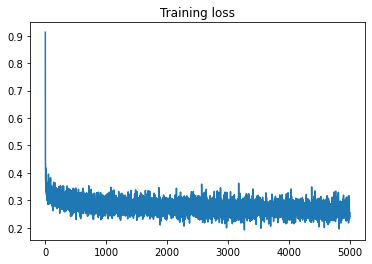

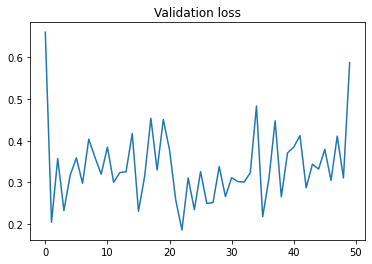

In [ ]:
start = timeit.default_timer()
for i in range(n_epoch):
  print(f"Starting Epoch {i+1} / {n_epoch}")
  # if i%30 == 0 and i > 10:
  #   torch.save(model.state_dict(), f'/content/drive/MyDrive/TFE/models/tmp_model_{i}.pth')

  #-----------------------------------------------------------------------------
  #   Training loop
  #-----------------------------------------------------------------------------
  tmp_losses = []
  model.train()
  for batch in train_input:  # load is a batch
    load = batch[0]
    x = batch[1]
    # iterate = list(range(T))
    # if shuffle:
      #  random.shuffle(iterate)
      #  iterate = [iterate[i] for i in range(5)]
      #  iterate = [iterate[1]]
    iterate = [int(np.random.rand()*T)]
    for t in iterate:

      optimizer.zero_grad()

      noise = torch.randn(load.shape)  
      
      noisy_input = sqrt(alpha_bar_t[t])*load + sqrt(1-alpha_bar_t[t])*noise # [Batch_size, 24]
      noisy_input = noisy_input.unsqueeze(1)   #[Batch_size, 1 ,24] (only if playng with convs)

      #Deal with gpu training
      noisy_input = noisy_input.to(device)
      noise = noise.to(device)
      x = x.to(device)
      t = torch.tensor(t)
      t = t.to(device)

      # Forward pass and loss computation
      if type_model == "conditional":
        out = model(noisy_input.float(), t, x.unsqueeze(1).float())
      else: 
        out = model(noisy_input.float(), t)

      out = out.squeeze(1)  #Only if playing with convolutions

      # kappa = (noise_schedule[t]**2) / (2*beta_tild_t[t]*alpha_t[t]*(1-alpha_bar_t[t]))
      # loss = kappa * criterion(out, noise)
      loss = criterion(out, noise)

      loss.backward()
      tmp_losses.append(loss.item())
      
      optimizer.step()  # When to update weights ? -> each noise step or each sample ?
  


  #-----------------------------------------------------------------------------
  #   Validation loop
  #-----------------------------------------------------------------------------
  if i % 100 == 0:
    tmp_val_loss = []
    model.eval()
    for batch in val_dataloader:
      load = batch[0]
      x = batch[1]
      # iterate = list(range(T))
      # if shuffle:
      #   random.shuffle(iterate)
      iterate = [int(np.random.rand()*T)]
      for t in iterate:

        noise = torch.randn(load.shape)  
        
        noisy_input = sqrt(alpha_bar_t[t])*load + sqrt(1-alpha_bar_t[t])*noise # [Batch_size, 24]
        noisy_input = noisy_input.unsqueeze(1)   #[Batch_size, 1 ,24] (only if playng with convs)

        #Deal with gpu training
        noisy_input = noisy_input.to(device)
        noise = noise.to(device)
        x = x.to(device)
        t = torch.tensor(t) 
        t = t.to(device)

        # Forward pass and loss computation
        if type_model == "conditional":
          out = model(noisy_input.float(), t, x.unsqueeze(1).float())
        else: 
          out = model(noisy_input.float(), t)
          
        out = out.squeeze(1)  #Only if playing with convolutions

        # kappa = (noise_schedule[t]**2) / (2*beta_tild_t[t]*alpha_t[t]*(1-alpha_bar_t[t]))
        # loss = kappa * criterion(out, noise)
        loss = criterion(out, noise)

        tmp_val_loss.append(loss.item())

  losses.append(np.mean(tmp_losses)) 
  if i % 100 == 0:
    validation_losses.append(np.mean(tmp_val_loss)) 
  stop = timeit.default_timer()
  print(f"Epoch {i+1} finished, estimeted time left: {time_format(round((n_epoch - i - 1) * (stop - start) / (i + 1)))}")




# today = datetime.datetime.now()
# date_time = today.strftime("%m/%d/%Y, %H:%M:%S")

# add_name = f"_ch_{residual_channels}_la_{residual_layers}"
add_name = f'_cha_{residual_channels}_la_{residual_layers}_dil_2_1t_no_kappa'
name_model = '/content/drive/MyDrive/TFE/models/' + tag  + '_' + type_model + '_' + 'model_diff_' + str(T) + '_epoch_' + str(n_epoch)
if shuffle:
   name_model += '_shuffle'
name_model += add_name
name_model += '.pth'
torch.save(model.state_dict(), name_model)
dump(y_LS_scaler, '/content/drive/MyDrive/TFE/' + tag + '_std_scaler_y.bin', compress=True)


plt.plot(losses)
plt.title("Training loss")
plt.show()
plt.clf()
plt.plot(validation_losses) 
plt.title("Validation loss")
plt.show()

              


#Sampling

In [ ]:
# model.eval()
# sample = model.sample(n_s=1)
# sample = sample.detach().numpy()
# print(y_LS_scaler.inverse_transform(sample))
# sample = y_LS_scaler.inverse_transform(sample)

# plt.plot(y_LS_scaler.inverse_transform(test_dataset[0][0].reshape(1,-1))[0])
# plt.plot(sample[0])
# plt.legend(["Real sample", "generated sample"])
# plt.show()

#Unconditional inference  (!! change name model)

In [ ]:
model = EpsilonThetaUncond()
model.load_state_dict(torch.load(f'/content/drive/MyDrive/TFE/models/unconditional/model_diff_200_epoch_100_shuffle.pth',map_location=torch.device('cpu')))
model.to(device)

def sample_infer_uncond(model, n_s=1):
   # Generate samples from Gaussian noise
        x_t = torch.randn(n_s, 24)
        
        for t in range(T-1, -1, -1):
            z = torch.randn(x_t.shape) if t > 1 else 0
            t = torch.tensor(t)
            t = t.to(device)

            eps_theta_t = model(x_t.unsqueeze(1).to(device), t)
            eps_theta_t = eps_theta_t.squeeze(1)

            mu = (x_t - ((noise_schedule[t] / sqrt(1-alpha_bar_t[t])) * eps_theta_t.to('cpu'))) / sqrt(alpha_t[t])
            sigma = torch.ones(mu.shape) * sqrt(beta_tild_t[t])

            x_t = mu + sigma*z  #other way of sampling
        
        scenarios = x_t

        return scenarios

sample = sample_infer_uncond(model, n_s= 1)
sample = sample.detach().numpy()
print(sample.shape)
sample = y_LS_scaler.inverse_transform(sample)

plt.plot(y_LS_scaler.inverse_transform(test_dataset[0][0].reshape(1,-1))[0])
plt.plot(sample[0])
plt.legend(["Real sample", "generated sample"])
plt.show()

TypeError: ignored

#Conditional Inference

[[ 9.4892788e-01  8.7856573e-01  7.9498118e-01  7.8857851e-01
   4.5644334e-01  3.6357668e-01  3.6000249e-01  1.9509365e-01
   2.2569190e-01  4.1201851e-01  3.2563531e-01  3.5922834e-01
   2.3943737e-01  1.0151310e-01  1.3109320e-02  3.5215258e-03
   3.6833209e-03 -1.2788824e-03  7.5708126e-04  1.1460773e-03
   5.5409512e-03  6.3940132e-04  4.3774238e-03  4.7048423e-03]]


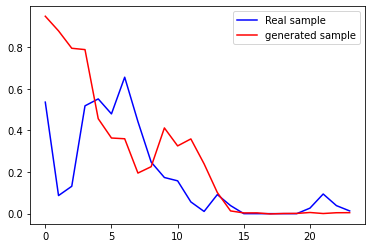

In [ ]:
# model = EpsilonThetaCond()
# model = EpsilonThetaCond(residual_layers = residual_layers, residual_channels=residual_channels)
model = EpsilonThetaCond(cond_length=cond_l, target_dim=target_d, residual_layers = residual_layers, residual_channels=residual_channels, dilation_cycle_length = 2)
model.load_state_dict(torch.load(f'/content/drive/MyDrive/TFE/models/exp_T/wind_conditional_model_diff_100_epoch_5000_shuffle_cha_8_la_8_dil_2_1t_no_kappa.pth',map_location=torch.device('cpu')))
model.eval()
model.to(device)

def sample_infer_cond(model, n_s=1, x_cond=None):
      x_t = torch.randn(n_s, target_d)
      context = torch.tensor(np.tile(x_cond, n_s).reshape(n_s, cond_l)).float()
          
        
      for t in range(T-1, -1, -1):
          z = torch.randn(x_t.shape) if t > 1 else 0
          t = torch.tensor(t)
          t = t.to(device)

          eps_theta_t = model(x_t.unsqueeze(1).to(device), t, context.unsqueeze(1).to(device))  
          eps_theta_t = eps_theta_t.squeeze(1)

          mu = (x_t - ((noise_schedule[t] / sqrt(1-alpha_bar_t[t])) * eps_theta_t.to('cpu'))) / sqrt(alpha_t[t])
          sigma = torch.ones(mu.shape) * sqrt(beta_tild_t[t])

          x_t = mu + sigma*z
      
      scenarios = x_t

      return scenarios


point = np.random.randint(0,len(test_dataset))
sample = sample_infer_cond(model, n_s= 1, x_cond=test_dataset[point][1])
sample = sample.detach().numpy()
print(y_LS_scaler.inverse_transform(sample))
sample = y_LS_scaler.inverse_transform(sample)

plt.plot(y_LS_scaler.inverse_transform(test_dataset[point][0].reshape(1,-1))[0], color='blue')
plt.plot(sample[0], color = 'red')
plt.legend(["Real sample", "generated sample"])
plt.show()

In [ ]:
print(tag)

wind


#Conditional scenario generation  (!! change name to save)

In [ ]:
def buildScenariosCond(model):
  n_s = 100
  n_days = len(test_dataset)
  scenarios = []
  for i in range(n_days): 
    sample = sample_infer_cond(model, n_s = n_s, x_cond = test_dataset[i][1])
    sample = sample.detach().numpy()
    sample = y_LS_scaler.inverse_transform(sample)
    scenarios.append(sample)
    
  return np.transpose(np.array(scenarios), (0, 2, 1)), test_dataset  # (n_days, 24, n_s) 


scenarios, ground_truth = buildScenariosCond(model)
print(scenarios.shape)

# add_name = f"_ch_{residual_channels}_la_{residual_layers}"
# add_name = f'_cha_{residual_channels}_la_{residual_layers}_dil_4'
# add_name = f'_cha_{residual_channels}_la_{residual_layers}_dil_2__1t'

with open('/content/drive/MyDrive/TFE/scenarios/exp_T/' + tag + "_diff_" + str(T) + "_epoch_" + str(n_epoch) + "_shuffle" + ".npy", 'wb') as f:
    np.save(f, scenarios)

with open('/content/drive/MyDrive/TFE/scenarios/exp_T/' + tag + "_gt" + "_diff_" + str(T) + ".npy", 'wb') as f:
    np.save(f, y_LS_scaler.inverse_transform(test_dataset[0:len(test_dataset)][0]))

(500, 24, 100)


#Interpolation in the latent space

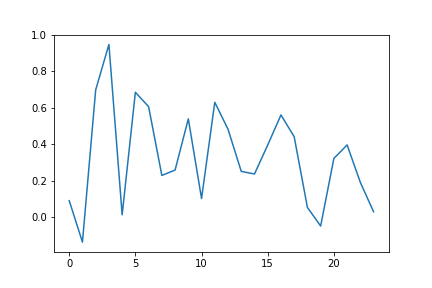

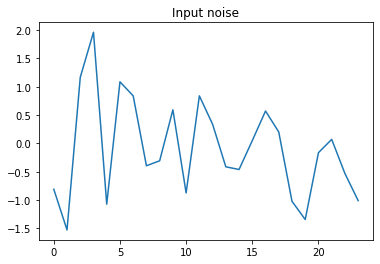

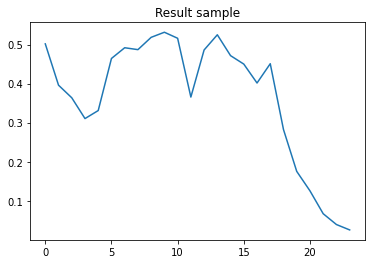

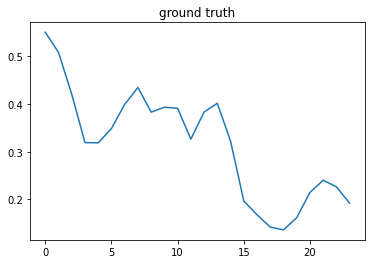

<Figure size 432x288 with 0 Axes>

In [ ]:
from IPython.display import Image

point = np.random.randint(0,len(test_dataset))
scenars = model.interpolate(test_dataset[point][1])

low = 1.5*np.min(y_LS_scaler.inverse_transform(scenars[-1])[0])
hi = 1.5*np.max(y_LS_scaler.inverse_transform(scenars[-1])[0])

display(Image(data=open('gif.gif','rb').read(), format='png'))

plt.plot(scenars[0][0])
plt.title("Input noise")
# plt.ylim(low, hi)
plt.show()
plt.clf()

plt.plot(y_LS_scaler.inverse_transform(scenars[-1])[0])
plt.title("Result sample")
# plt.ylim(low, hi)
plt.show()
plt.clf()

plt.plot(y_LS_scaler.inverse_transform(test_dataset[point][0].reshape(1,-1))[0])
plt.title("ground truth")
# plt.ylim(low, hi)
plt.show()
plt.clf()


#Unconditional Generation (!! change name to save)

In [ ]:
def buildScenariosUncond(model):
  n_s = 100
  n_days = len(test_dataset)
  scenarios = []
  for i in range(n_days):
    sample = sample_infer_uncond(model, n_s = n_s)
    sample = sample.detach().numpy()
    sample = y_LS_scaler.inverse_transform(sample)
    scenarios.append(sample)
    
  return np.transpose(np.array(scenarios), (0, 2, 1)), test_dataset  # (n_days, 24, n_s) 


scenarios, ground_truth = buildScenariosUncond(model)
print(scenarios.shape)

with open('/content/drive/MyDrive/TFE/scenarios/unconditional/' + "model_diff_200_epoch_100_shuffle" + ".npy", 'wb') as f:
    np.save(f, scenarios)

with open('/content/drive/MyDrive/TFE/scenarios/unconditional/' + "gt_200_100" + ".npy", 'wb') as f:
    np.save(f, y_LS_scaler.inverse_transform(test_dataset[0:len(test_dataset)][0]))

(50, 24, 100)


In [ ]:
test_dataset[0:len(test_dataset)][0].shape

(50, 24)

# Sampling experiments


In [9]:
T = 400
noise_schedule = np.linspace(1e-4, 0.05, T).tolist() #beta_t
alpha_t = [1-beta_t for beta_t in noise_schedule]
alpha_bar_t = [alpha_t[0] if s == 0 else reduce((lambda x,y: x*y), alpha_t[:s]) for s in range(len(noise_schedule))]
beta_tild_t = [noise_schedule[0] if t == 0 else ((1-alpha_bar_t[t-1]) / (1-alpha_bar_t[t]))*noise_schedule[t] for t in range(len(noise_schedule))]  

diff_params = [noise_schedule, alpha_t, alpha_bar_t, beta_tild_t ]

alpha_bar_t = torch.tensor(alpha_bar_t)

[[0.54833704 0.59136915 0.6736583  0.652239   0.5428587  0.8118509
  0.7239428  0.38171777 0.44878623 0.4140483  0.38168582 0.37723124
  0.6422283  0.5941001  0.5545412  0.63394916 0.8538988  0.8273061
  0.86721236 0.88745993 0.91111815 0.9211552  0.8806104  0.86913085]]


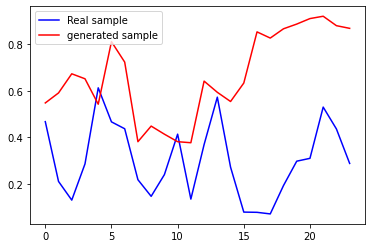

In [15]:
# model = EpsilonThetaCond()
# model = EpsilonThetaCond(residual_layers = residual_layers, residual_channels=residual_channels)
# dil = 2

# model = EpsilonThetaCond(cond_length=cond_l, target_dim=target_d, residual_layers = residual_layers, residual_channels=residual_channels, dilation_cycle_length=dil)
model.load_state_dict(torch.load(f'/content/drive/MyDrive/TFE/models/exp_T/wind_conditional_model_diff_400_epoch_5000_shuffle_cha_8_la_8_dil_2_small.pth',map_location=torch.device('cpu')))

model.to(device)

def fastSample(model, n_s=1, x_cond=None, frac = 1):
      x_t = torch.randn(n_s, target_d)
      context = torch.tensor(np.tile(x_cond, n_s).reshape(n_s, cond_l)).float()
      T_infer = int(frac * T)
      skip = T//T_infer
      for t in range(T-1, -1, -1):
          if t % skip:
            continue
          z = torch.randn(x_t.shape) if t > 1 else 0
          t = torch.tensor(t)
          t = t.to(device)

          eps_theta_t = model(x_t.unsqueeze(1).to(device), t, context.unsqueeze(1).to(device))  
          eps_theta_t = eps_theta_t.squeeze(1)

          mu = (x_t - ((noise_schedule[t] / sqrt(1-alpha_bar_t[t])) * eps_theta_t.to('cpu'))) / sqrt(alpha_t[t])
          sigma = torch.ones(mu.shape) * sqrt(beta_tild_t[t])

          x_t = mu + sigma*z
      
      scenarios = x_t

      return scenarios


point = np.random.randint(0,len(test_dataset))
sample = fastSample(model, n_s = 1, x_cond=test_dataset[point][1])
sample = sample.detach().numpy()
print(y_LS_scaler.inverse_transform(sample))
sample = y_LS_scaler.inverse_transform(sample)

plt.plot(y_LS_scaler.inverse_transform(test_dataset[point][0].reshape(1,-1))[0], color='blue')
plt.plot(sample[0], color = 'red')
plt.legend(["Real sample", "generated sample"])
plt.show()

# Scenario generation  fast sampling

In [16]:
def buildScenariosFast(model,frac = 1):
  n_s = 100
  n_days = len(test_dataset)
  scenarios = []
  for i in range(n_days):
    sample = fastSample(model, n_s = n_s, x_cond = test_dataset[i][1], frac = frac)
    sample = sample.detach().numpy()
    sample = y_LS_scaler.inverse_transform(sample)
    scenarios.append(sample)
    
  return np.transpose(np.array(scenarios), (0, 2, 1)), test_dataset  # (n_days, 24, n_s) 


model.eval()
for frac in [0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1]:
  scenarios, ground_truth = buildScenariosFast(model, frac)
  print(scenarios.shape)

  # add_name = f"_ch_{residual_channels}_la_{residual_layers}_dil_{dil}_1t"
  # add_name = f'_cha_{residual_channels}_la_{residual_layers}_dil_{dil}_1t_no_kappa'

  # add_name = "_small_3"
  with open('/content/drive/MyDrive/TFE/scenarios/fast_sample/' + tag + "_diff_" + str(T) +  "_" + str(int(frac*T)) + ".npy", 'wb') as f:
      np.save(f, scenarios)

  with open('/content/drive/MyDrive/TFE/scenarios/fast_sample/' + tag + "_gt_"  + str(int(frac*T)) + ".npy", 'wb') as f:
      np.save(f, y_LS_scaler.inverse_transform(test_dataset[0:len(test_dataset)][0]))

(500, 24, 100)
(500, 24, 100)
(500, 24, 100)
(500, 24, 100)
(500, 24, 100)
(500, 24, 100)
(500, 24, 100)
